<a href="https://colab.research.google.com/github/Mifekmk/SkillTreePython-DeepLearning/blob/main/02.%EC%BC%80%EB%9D%BC%EC%8A%A4_%EC%B0%BD%EC%8B%9C%EC%9E%90%EC%97%90%EA%B2%8C_%EB%B0%B0%EC%9A%B0%EB%8A%94_%EB%94%A5%EB%9F%AC%EB%8B%9D/5_3_using_a_pretrained_convnet_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 세팅
---

```
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning
```

In [39]:
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning

fatal: destination path 'SkillTreePython-DeepLearning' already exists and is not an empty directory.


```
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/02.케라스_창시자에게_배우는_딥러닝/scripts')
from import_lib import *
```

In [40]:
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/02.케라스_창시자에게_배우는_딥러닝/scripts')
from import_lib import *

# 사전 훈련된 컨브넷 사용하기

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/) 책의 5장 3절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다.

----

작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 사전 훈련된 네트워크를 사용하는 것입니다. 사전 훈련된 네트워크는 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크입니다. 원본 데이터셋이 충분히 크고 일반적이라면 사전 훈련된 네트워크에 의해 학습된 특성의 계층 구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있습니다. 새로운 문제가 원래 작업과 완전히 다른 클래스에 대한 것이더라도 이런 특성은 많은 컴퓨터 비전 문제에 유용합니다. 예를 들어 (대부분 동물이나 생활 용품으로 이루어진) ImageNet 데이터셋에 네트워크를 훈련합니다. 그다음 이 네트워크를 이미지에서 가구 아이템을 식별하는 것 같은 다른 용도로 사용할 수 있습니다. 학습된 특성을 다른 문제에 적용할 수 있는 이런 유연성은 이전의 많은 얕은 학습 방법과 비교했을 때 딥러닝의 핵심 장점입니다. 이런 방식으로 작은 데이터셋을 가진 문제에도 딥러닝이 효율적으로 작동할 수 있습니다.

여기에서는 (1.4백만 개의 레이블된 이미지와 1,000개의 클래스로 이루어진) ImageNet 데이터셋에서 훈련된 대규모 컨브넷을 사용해 보겠습니다. ImageNet 데이터셋은 다양한 종의 강아지와 고양이를 포함해 많은 동물들을 포함하고 있습니다. 그래서 강아지 vs. 고양이 분류 문제에 좋은 성능을 낼 것 같습니다.

캐런 시몬연과 앤드류 지서먼이 2014년에 개발한 VGG16 구조를 사용하겠습니다. VGG16은 간단하고 ImageNet 데이터셋에 널리 사용되는 컨브넷 구조입니다. VGG16은 조금 오래되었고 최고 수준의 성능에는 못미치며 최근의 다른 모델보다는 조금 무겁습니다. 하지만 이 모델의 구조가 이전에 보았던 것과 비슷해서 새로운 개념을 도입하지 않고 이해하기 쉽기 때문에 선택했습니다. 아마 VGG가 처음 보는 모델 애칭일지 모르겠습니다. 이런 이름에는 VGG, ResNet, Inception, Inception-ResNet, Xception 등이 있습니다. 컴퓨터 비전을 위해 딥러닝을 계속 공부하다보면 이런 이름을 자주 만나게 될 것입니다.

사전 훈련된 네트워크를 사용하는 두 가지 방법이 있습니다. 특성 추출과 미세 조정입니다. 이 두 가지를 모두 다루어 보겠습니다. 먼저 특성 추출부터 시작하죠.

## 특성 추출

특성 추출은 사전에 학습된 네트워크의 표현을 사용해 새로운 샘플에서 흥미로운 특성을 뽑아내는 것입니다. 이런 특성을 사용하여 새로운 분류기를 처음부터 훈련합니다.

앞서 보았듯이 컨브넷은 이미지 분류를 위해 두 부분으로 구성됩니다. 먼저 연속된 합성곱과 풀링 층으로 시작해서 완전 연결 분류기로 끝납니다. 첫 번째 부분을 모델의 합성곱 기반층(convolutional base)이라고 부르겠습니다. 컨브넷의 경우 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반층을 선택해 새로운 데이터를 통과시키고 그 출력으로 새로운 분류기를 훈련합니다.

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

왜 합성곱 층만 재사용할까요? 완전 연결 분류기도 재사용할 수 있을까요? 일반적으로 권장하지 않습니다. 합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용 가능하기 때문입니다. 컨브넷의 특성 맵은 사진에 대한 일반적인 컨셉의 존재 여부를 기록한 맵입니다. 그래서 주어진 컴퓨터 비전 문제에 상관없이 유용하게 사용할 수 있습니다. 하지만 분류기에서 학습한 표현은 모델이 훈련된 클래스 집합에 특화되어 있습니다. 분류기는 전체 사진에 어떤 클래스가 존재할 확률에 관한 정보만을 담고 있습니다. 더군다나 완전 연결 층에서 찾은 표현은 더 이상 입력 이미지에 있는 객체의 위치 정보를 가지고 있지 않습니다. 완전 연결 층들은 공간 개념을 제거하지만 합성곱의 특성 맵은 객체의 위치를 고려합니다. 객체의 위치가 중요한 문제라면 완전 연결 층에서 만든 특성은 크게 쓸모가 없습니다.

특정 합성곱 층에서 추출한 표현의 일반성(그리고 재사용성)의 수준은 모델에 있는 층의 깊이에 달려 있습니다. 모델의 하위 층은 (에지, 색깔, 질감 등과 같이) 지역적이고 매우 일반적인 특성 맵을 추출합니다. 반면 상위 층은 ('강아지 눈'이나 '고양이 귀'와 같이) 좀 더 추상적인 개념을 추출합니다. 만약 새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르다면 전체 합성곱 기반층을 사용하는 것보다는 모델의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋습니다.

ImageNet의 클래스 집합에는 여러 종류의 강아지와 고양이를 포함하고 있습니다. 이런 경우 원본 모델의 완전 연결 층에 있는 정보를 재사용하는 것이 도움이 될 것 같습니다. 하지만 새로운 문제의 클래스가 원본 모델의 클래스 집합과 겹치지 않는 좀 더 일반적인 경우를 다루기 위해서 여기서는 완전 연결 층을 사용하지 않겠습니다.

ImageNet 데이터셋에 훈련된 VGG16 네트워크의 합성곱 기반층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출해 보겠습니다. 그런 다음 이 특성으로 강아지 vs. 고양이 분류기를 훈련합니다.

VGG16 모델은 케라스에 패키지로 포함되어 있습니다. `keras.applications` 모듈에서 임포트할 수 있습니다. `keras.applications` 모듈에서 사용 가능한 이미지 분류 모델은 다음과 같습니다(모두 ImageNet 데이터셋에서 훈련되었습니다):

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

VGG16 모델을 만들어 보죠:

In [41]:
IMG_SHAPE = (150, 150, 3)
base_model = applications.VGG16(weights='imagenet', # 이미지넷 데이터로 사전 학습된 학습 파라미터
                                include_top=False, # 최상위 층 (flatten이후) 제거
                                input_shape= IMG_SHAPE

                                )

VGG16 함수에 세 개의 매개변수를 전달합니다:

* `weights`는 모델을 초기화할 가중치 체크포인트를 지정합니다.
* `include_top`은 네트워크의 최상위 완전 연결 분류기를 포함할지 안할지를 지정합니다. 기본값은 ImageNet의 1,000개의 클래스에 대응되는 완전 연결 분류기를 포함합니다. 별도의 (강아지와 고양이 두 개의 클래스를 구분하는) 완전 연결 층을 추가하려고 하므로 이를 포함시키지 않습니다.
* `input_shape`은 네트워크에 주입할 이미지 텐서의 크기입니다. 이 매개변수는 선택사항입니다. 이 값을 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리할 수 있습니다.

다음은 VGG16 합성곱 기반층의 자세한 구조입니다. 이 구조는 앞에서 보았던 간단한 컨브넷과 비슷합니다.

In [42]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

최종 특성 맵의 크기는 `(4, 4, 512)`입니다. 이 특성 위에 완전 연결 층을 놓을 것입니다.
이 지점에서 두 가지 방식이 가능합니다.

* 새로운 데이터셋에서 합성곱 기반층을 실행하고 출력을 넘파이 배열로 디스크에 저장합니다. 그다음 이 데이터를 이 책의 1부에서 보았던 것과 비슷한 독립된 완전 연결 분류기에 입력으로 사용합니다. 합성곱 연산은 전체 과정 중에서 가장 비싼 부분입니다. 이 방식은 모든 입력 이미지에 대해 합성곱 기반층을 한 번만 실행하면 되기 때문에 빠르고 비용이 적게 듭니다. 하지만 이런 이유 때문에 이 기법에는 데이터 증식을 사용할 수 없습니다.
* 준비한 모델(`conv_base`) 위에 `Dense` 층을 쌓아 확장합니다. 그다음 입력 데이터에서 엔드 투 엔드로 전체 모델을 실행합니다. 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과하기 때문에 데이터 증식을 사용할 수 있습니다. 하지만 이런 이유로 이 방식은 첫 번째 방식보다 훨씬 비용이 많이 듭니다.

먼저 앞서 소개한 `ImageDataGenerator`를 사용해 이미지와 레이블을 넘파이 배열로 추출하겠습니다. `conv_base` 모델의 `predict` 메서드를 호출하여 이 이미지에서 특성을 추출합니다.

```
! git clone https://github.com/gilbutITbook/006975
```

In [43]:
# 1. x -> vgg.predict -> z -> model(train) -> y : 장점 - 학습이 빠르다, 단점 - 증강 사용이 불가합니다.
# 2. x -> new_model(vgg+model) -> y : 장점 - 데이터 증강이 사용가능, 단점 - 학습이 느립니다.


이제 특성 추출을 위해 두 번째로 언급한 방법을 살펴보겠습니다. 이 방법은 훨씬 느리고 비용이 많이 들지만 훈련하는 동안 데이터 증식 기법을 사용할 수 있습니다. `conv_base` 모델을 확장하고 입력 데이터를 사용해 엔드 투 엔드로 실행합니다.

이 기법은 연산 비용이 크기 때문에 GPU를 사용할 수 있을 때 시도해야 합니다. CPU에서는 적용하기 매우 힘듭니다. GPU를 사용할 수 없다면 첫 번째 방법을 사용하세요.

모델은 층과 동일하게 작동하므로 층을 추가하듯이 `Sequential` 모델에 (`conv_base` 같은) 다른 모델을 추가할 수 있습니다:

In [44]:
# 전이학습 : transfer learning
def create_transfer(base_model):
    x = layers.Input(shape=IMG_SHAPE)
    y = base_model(x) # y : (4,4,512)
    y = layers.Flatten()(y)
    y = layers.Dense(256, activation='relu')(y)
    y = layers.Dense(1, activation='sigmoid')(y)
    return models.Model(x,y)

이 모델의 구조는 다음과 같습니다:

In [45]:
model = create_transfer(base_model)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


여기서 볼 수 있듯이 VGG16의 합성곱 기반층은 14,714,688개의 매우 많은 파라미터를 가지고 있습니다. 합성곱 기반층 위에 추가한 분류기는 2백만 개의 파라미터를 가집니다.

모델을 컴파일하고 훈련하기 전에 합성곱 기반층을 동결하는 것이 아주 중요합니다. 하나 이상의 층을 동결한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻입니다. 이렇게 하지 않으면 합성곱 기반층에 의해 사전에 학습된 표현이 훈련하는 동안 수정될 것입니다. 맨 위의 `Dense` 층은 랜덤하게 초기화되었기 때문에 매우 큰 가중치 업데이트 값이 네트워크에 전파될 것입니다. 이는 사전에 학습된 표현을 크게 훼손하게 됩니다.

케라스에서는 `trainable` 속성을 `False`로 설정하여 네트워크를 동결할 수 있습니다:

In [46]:
print(f'vgg 동결 전 훈련되는 레이어 수 : {len(model.trainable_weights)}')

vgg 동결 전 훈련되는 레이어 수 : 30


In [47]:
base_model.trainable = False

In [48]:
print(f'vgg 동결 후 훈련되는 레이어 수 : {len(model.trainable_weights)}')

vgg 동결 후 훈련되는 레이어 수 : 4


In [49]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


이렇게 설정하면 추가한 두 개의 `Dense` 층의 가중치만 훈련될 것입니다. 층마다 두 개씩(가중치 행렬과 편향 벡터) 총 네 개의 텐서가 훈련됩니다. 변경 사항을 적용하려면 먼저 모델을 컴파일해야 합니다. 컴파일 단계 후에 `trainable` 속성을 변경하면 반드시 모델을 다시 컴파일해야 합니다. 그렇지 않으면 변경 사항이 적용되지 않습니다.

이제 앞의 예제에서 사용했던 데이터 증식을 사용하여 모델 훈련을 시작할 수 있습니다:

In [50]:
! git clone https://github.com/gilbutITbook/006975

fatal: destination path '006975' already exists and is not an empty directory.


In [ ]:
# from set_dataset import set_dogs_and_cats
# set_dogs_and_cats('/content/006975/datasets/cats_and_dogs/train',
#                   '/content/cats_and_dogs') # 소스 이미지 폴더, 새로 생성할 폴더

In [52]:
from tensorflow.keras.preprocessing import image

# 데이터 제너레이터 생성
aug_gen = image.ImageDataGenerator(rescale=1.0/255.0,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2, 
                             horizontal_flip=True,
                             fill_mode='nearest',
                             brightness_range = [0.7,1.3]                            
                             )
gen = image.ImageDataGenerator(rescale=1.0/255.0)

train_gen = aug_gen.flow_from_directory('/content/cats_and_dogs/train',
                                        target_size = IMG_SHAPE[:2], # H, W만 써줍니다.
                                        batch_size=20,
                                        class_mode = 'binary', # 이진 분류
                                        )

gen = image.ImageDataGenerator(rescale=1.0/255.0)
valid_gen = aug_gen.flow_from_directory('/content/cats_and_dogs/valid',
                                        target_size = IMG_SHAPE[:2], # H, W만 써줍니다.
                                        batch_size=20,
                                        class_mode = 'binary', # 이진 분류
                                        )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [54]:
# 사전 학습된 모델을 불러옵니다.
vgg = applications.VGG16(weights='imagenet',
                         include_top=False, # 마지막 불류기는 제거
                         input_shape=IMG_SHAPE
                         )
vgg.trainable = False # 사전 학습된 모델은 훈련을 하지 않도록 합니다.
model = create_transfer(vgg)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               2097408   
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [55]:
# 0.001/0.0001
from tensorflow.keras import optimizers
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=2e-5), # 전이학습 시에는 학습률을 작게 설정해주기
              metrics = ['acc']
              )
tb = callbacks.TensorBoard(log_dir='transfer_log',
                           histogram_freq=1
                           )
ckp = callbacks.ModelCheckpoint(filepath='transfer_vgg.h5',
                                save_best_only=True,
                                monitor='val_acc',
                                )
history = model.fit(train_gen,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=valid_gen,
                    validation_steps=50,
                    callbacks=[tb, ckp])

Epoch 1/30
100/100 [==============================] - 30s 298ms/step - loss: 0.5754 - acc: 0.7165 - val_loss: 0.5217 - val_acc: 0.7630
Epoch 2/30
100/100 [==============================] - 31s 310ms/step - loss: 0.4736 - acc: 0.7910 - val_loss: 0.4447 - val_acc: 0.8030
Epoch 3/30
100/100 [==============================] - 32s 316ms/step - loss: 0.4173 - acc: 0.8235 - val_loss: 0.4330 - val_acc: 0.8040
Epoch 4/30
100/100 [==============================] - 31s 309ms/step - loss: 0.3985 - acc: 0.8245 - val_loss: 0.3860 - val_acc: 0.8270
Epoch 5/30
100/100 [==============================] - 30s 298ms/step - loss: 0.3965 - acc: 0.8190 - val_loss: 0.3799 - val_acc: 0.8450
Epoch 6/30
100/100 [==============================] - 30s 296ms/step - loss: 0.3699 - acc: 0.8340 - val_loss: 0.3872 - val_acc: 0.8280
Epoch 7/30
100/100 [==============================] - 30s 297ms/step - loss: 0.3542 - acc: 0.8470 - val_loss: 0.3637 - val_acc: 0.8280
Epoch 8/30
100/100 [==============================] - 2

결과 그래프를 다시 그려 봅시다:

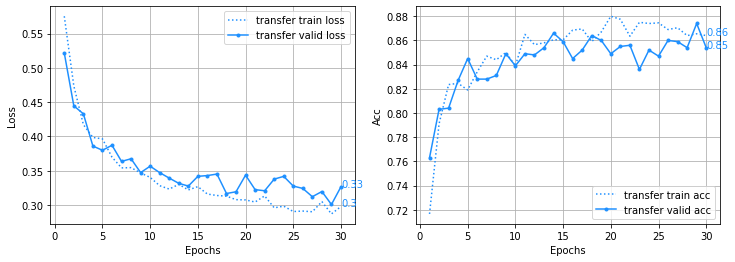

In [56]:
from plot_result import *
plot_lcurve([history], ['transfer'], ['dodgerblue'], x_itv=5)

In [57]:
transfer = models.load_model('/content/transfer_vgg.h5')
transfer.evaluate(valid_gen)

50/50 [==============================] - 9s 176ms/step - loss: 0.3199 - acc: 0.8570


[0.31985747814178467, 0.8569999933242798]

여기서 볼 수 있듯이 검증 정확도가 이전과 비슷하지만 처음부터 훈련시킨 소규모 컨브넷보다 과대적합이 줄었습니다.

In [58]:
%load_ext tensorboard

In [61]:
log_dir = '/content/transfer_vgg.h5'
%tensorboard --logdir$log_dir

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [-

## 미세 조정

모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세 조정입니다. 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것입니다. 주어진 문제에 조금 더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 미세 조정이라고 부릅니다.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

앞서 랜덤하게 초기화된 상단 분류기를 훈련하기 위해 VGG16의 합성곱 기반층을 동결해야 한다고 말했습니다. 같은 이유로 맨 위에 있는 분류기가 훈련된 후에 합성곱 기반의 상위 층을 미세 조정할 수 있습니다. 분류기가 미리 훈련되지 않으면 훈련되는 동안 너무 큰 오차 신호가 네트워크에 전파됩니다. 이는 미세 조정될 층들이 사전에 학습한 표현들을 망가뜨리게 될 것입니다. 네트워크를 미세 조정하는 단계는 다음과 같습니다:

1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가합니다.
2. 기반 네트워크를 동결합니다.
3. 새로 추가한 네트워크를 훈련합니다.
4. 기반 네트워크에서 일부 층의 동결을 해제합니다.
5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련합니다.

처음 세 단계는 특성 추출을 할 때 이미 완료했습니다. 네 번째 단계를 진행해 보죠. `conv_base`의 동결을 해제하고 개별 층을 동결하겠습니다.

기억을 되살리기 위해 합성곱 기반층의 구조를 다시 확인해 보겠습니다:

In [66]:
model = create_transfer(vgg)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               2097408   
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


마지막 세 개의 합성곱 층을 미세 조정하겠습니다. 즉, `block4_pool`까지 모든 층은 동결되고 `block5_conv1`, `block5_conv2`, `block5_conv3` 층은 학습 대상이 됩니다.

왜 더 많은 층을 미세 조정하지 않을까요? 왜 전체 합성곱 기반층을 미세 조정하지 않을까요? 그렇게 할 수도 있지만 다음 사항을 고려해야 합니다:

* 합성곱 기반층에 있는 하위 층들은 좀 더 일반적이고 재사용 가능한 특성들을 인코딩합니다. 반면 상위 층은 좀 더 특화된 특성을 인코딩합니다. 새로운 문제에 재활용하도록 수정이 필요한 것은 구체적인 특성이므로 이들을 미세 조정하는 것이 유리합니다. 하위 층으로 갈수록 미세 조정에 대한 효과가 감소합니다.
* 훈련해야 할 파라미터가 많을수록 과대적합의 위험이 커집니다. 합성곱 기반층은 1천 5백만 개의 파라미터를 가지고 있습니다. 작은 데이터셋으로 전부 훈련하려고 하면 매우 위험합니다.

그러므로 이런 상황에서는 합성곱 기반층에서 최상위 두 세개의 층만 미세 조정하는 것이 좋습니다.

앞선 예제 코드에 이어서 미세 조정을 설정해보죠:

In [69]:
# 사전 학습된 모델을 불러옵니다.
vgg = applications.VGG16(weights='imagenet',
                         include_top=False, # 마지막 분류기는 제거
                         input_shape=IMG_SHAPE
                         )

# vgg.trainble # 전체 모델 고정/고정해제
for i, layer in enumerate(vgg.layers):
    print(i, layer)
    if i<15: layer.trainable=False # 하위층은 학습 하지 않게 한다.
    else: layer.trainable=True # 상위층은 학습 하도록 합니다.

0 <keras.engine.input_layer.InputLayer object at 0x7f0b726fd810>
1 <keras.layers.convolutional.Conv2D object at 0x7f0b726fd0d0>
2 <keras.layers.convolutional.Conv2D object at 0x7f0b726e88d0>
3 <keras.layers.pooling.MaxPooling2D object at 0x7f0b723b7850>
4 <keras.layers.convolutional.Conv2D object at 0x7f0b72776b50>
5 <keras.layers.convolutional.Conv2D object at 0x7f0b7270aa90>
6 <keras.layers.pooling.MaxPooling2D object at 0x7f0b7270d5d0>
7 <keras.layers.convolutional.Conv2D object at 0x7f0b728e1bd0>
8 <keras.layers.convolutional.Conv2D object at 0x7f0b72709490>
9 <keras.layers.convolutional.Conv2D object at 0x7f0b7277c4d0>
10 <keras.layers.pooling.MaxPooling2D object at 0x7f0b72742e10>
11 <keras.layers.convolutional.Conv2D object at 0x7f0b7270bcd0>
12 <keras.layers.convolutional.Conv2D object at 0x7f0b723b6a50>
13 <keras.layers.convolutional.Conv2D object at 0x7f0b727bfcd0>
14 <keras.layers.pooling.MaxPooling2D object at 0x7f0b726fd4d0>
15 <keras.layers.convolutional.Conv2D object at 

In [70]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

이제 네트워크의 미세 조정을 시작하겠습니다. 학습률을 낮춘 RMSProp 옵티마이저를 사용합니다. 학습률을 낮추는 이유는 미세 조정하는 세 개의 층에서 학습된 표현을 조금씩 수정하기 위해서입니다. 변경량이 너무 크면 학습된 표현에 나쁜 영향을 끼칠 수 있습니다.

미세 조정을 진행해 보죠:

In [ ]:
# 이미 위에서 전이학습을 진행 했다. -> 전이학습으로 학습 파라미터가 조정이 되었습니다.
# 지금은 새로 모델 껍데기를 만든 상태
# 보통 전이학습으로 파라미터 업데이트 -> 미세조정으로 파라미터 재업데이트

In [71]:
model.set_weights(transfer.weights) # 전이학습 파라미터를 가져오기

In [74]:
from tensorflow.keras import optimizers
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=1e-5), # 튜닝학습 시에는 학습률을 더 작게 설정해주기
              metrics = ['acc']
              )
tb = callbacks.TensorBoard(log_dir='finerune_transfer_log',
                           histogram_freq=1
                           )
ckp = callbacks.ModelCheckpoint(filepath='finetune_vgg.h5',
                                save_best_only=True,
                                monitor='val_acc',
                                )
history = model.fit(train_gen,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=valid_gen,
                    validation_steps=50,
                    callbacks=[tb, ckp])

Epoch 1/30
100/100 [==============================] - 31s 299ms/step - loss: 0.2853 - acc: 0.8895 - val_loss: 0.3290 - val_acc: 0.8490
Epoch 2/30
100/100 [==============================] - 31s 310ms/step - loss: 0.2836 - acc: 0.8740 - val_loss: 0.3152 - val_acc: 0.8580
Epoch 3/30
100/100 [==============================] - 29s 295ms/step - loss: 0.2807 - acc: 0.8885 - val_loss: 0.3380 - val_acc: 0.8390
Epoch 4/30
100/100 [==============================] - 29s 294ms/step - loss: 0.2830 - acc: 0.8830 - val_loss: 0.3025 - val_acc: 0.8660
Epoch 5/30
100/100 [==============================] - 29s 291ms/step - loss: 0.2795 - acc: 0.8790 - val_loss: 0.3208 - val_acc: 0.8540
Epoch 6/30
100/100 [==============================] - 29s 292ms/step - loss: 0.2765 - acc: 0.8835 - val_loss: 0.3153 - val_acc: 0.8640
Epoch 7/30
100/100 [==============================] - 29s 291ms/step - loss: 0.2778 - acc: 0.8790 - val_loss: 0.3239 - val_acc: 0.8440
Epoch 8/30
100/100 [==============================] - 2

이전과 동일한 코드로 결과 그래프를 그려 보겠습니다:

검증 정확도 곡선이 훨씬 깨끗하게 보입니다. 정확도가 확실히 1% 이상 향상되었습니다.

손실 곡선은 실제 어떤 향상을 얻지 못했습니다(사실 악화되었습니다). 손실히 감소되지 않았는데 어떻게 정확도가 안정되거나 향상될 수 있을까요? 답은 간단합니다. 그래프는 개별적인 손실 값의 평균을 그린 것입니다. 하지만 정확도에 영향을 미치는 것은 손실 값의 분포이지 평균이 아닙니다. 정확도는 모델이 예측한 클래스 확률이 어떤 임계값을 넘었는지에 대한 결과이기 때문입니다. 모델이 더 향상더라도 평균 손실에 반영되지 않을 수 있습니다.

이제 마지막으로 테스트 데이터에서 이 모델을 평가하겠습니다:

In [77]:
finetune = models.load_model('/content/finetune_vgg.h5')
finetune.evaluate(valid_gen)

50/50 [==============================] - 9s 179ms/step - loss: 0.3072 - acc: 0.8680


[0.3071550726890564, 0.8679999709129333]

In [78]:
gen = image.ImageDataGenerator(rescale=1.0/255.0)
test_gen = aug_gen.flow_from_directory('/content/cats_and_dogs/test',
                                        target_size = IMG_SHAPE[:2], # H, W만 써줍니다.
                                        batch_size=20,
                                        class_mode = 'binary', # 이진 분류
                                        )

Found 1000 images belonging to 2 classes.


92%의 테스트 정확도를 얻을 것입니다. 이 데이터셋을 사용한 원래 캐글 경연 대회에서 꽤 높은 순위입니다. 하지만 최신 딥러닝 기법으로 훈련 데이터의 일부분(약 10%)만을 사용해서 이런 결과를 달성했습니다. 20,000개의 샘플에서 훈련하는 것과 2,000개의 샘플에서 훈련하는 것 사이에는 아주 큰 차이점이 있습니다!

## 정리

다음은 앞의 두 절에 있는 예제로부터 배운 것들입니다.

* 컨브넷은 컴퓨터 비전 작업에 가장 뛰어난 머신 러닝 모델입니다. 아주 작은 데이터셋에서도 처음부터 훈련해서 괜찮은 성능을 낼 수 있습니다.
* 작은 데이터셋에서는 과대적합이 큰 문제입니다. 데이터 증식은 이미지 데이터를 다룰 때 과대적합을 막을 수 있는 강력한 방법입니다.
* 특성 추출 방식으로 새로운 데이터셋에 기존의 컨브넷을 쉽게 재사용할 수 있습니다. 작은 이미지 데이터셋으로 작업할 때 효과적인 기법입니다.
* 특성 추출을 보완하기 위해 미세 조정을 사용할 수 있습니다. 미세 조정은 기존 모델에서 사전에 학습한 표현의 일부를 새로운 문제에 적응시킵니다. 이 기법은 조금 더 성능을 끌어올립니다.

지금까지 이미지 분류 문제에서 특히 작은 데이터셋을 다루기 위한 좋은 도구들을 배웠습니다.

## 과제 1
---
아래 텐서플로우  '전이학습 및 미세 조정' 튜토리얼을 따라 작성하세요.

https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [80]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

68616192/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [81]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


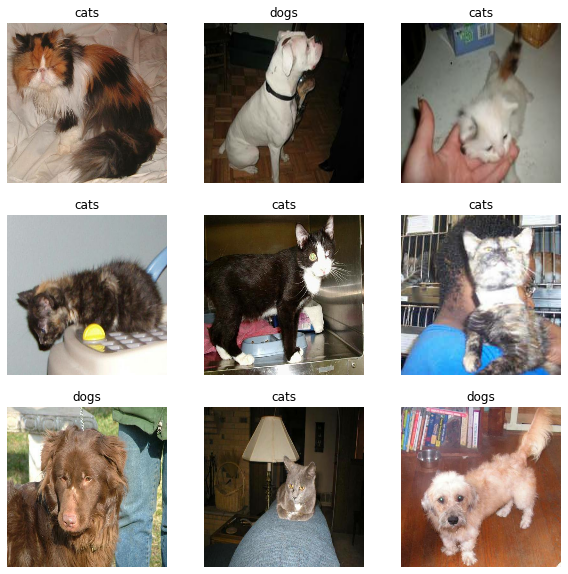

In [84]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [85]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches// 5)

In [86]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [87]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [91]:
data_argumentation = tf.keras.Sequential([
                                          tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                          tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

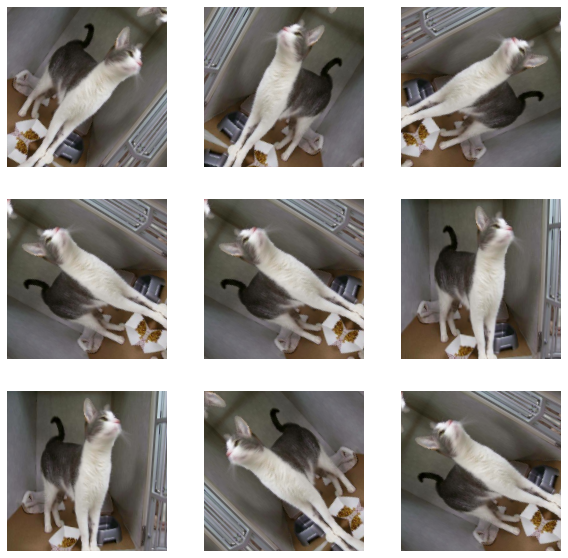

In [94]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_argumentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [95]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [96]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/127.5, offset=-1)

In [97]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [98]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [99]:
base_model.trainable = False

In [100]:
# 기본 모델 아키텍처를 살펴봅니다.
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_19[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [101]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [102]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [104]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_argumentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [105]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [106]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [107]:
len(model.trainable_variables)

2

In [108]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 4s 47ms/step - loss: 0.8732 - accuracy: 0.5074


In [109]:
print('initial loss: {:.2f}'.format(loss0))
print('initial accuracy: {:.2f}'.format(accuracy0))

initial loss: 0.87
initial accuracy: 0.51


In [110]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 7s 64ms/step - loss: 0.7112 - accuracy: 0.5760 - val_loss: 0.5383 - val_accuracy: 0.6386
Epoch 2/10
63/63 [==============================] - 5s 81ms/step - loss: 0.5193 - accuracy: 0.7060 - val_loss: 0.3841 - val_accuracy: 0.7710
Epoch 3/10
63/63 [==============================] - 6s 91ms/step - loss: 0.4193 - accuracy: 0.7820 - val_loss: 0.2985 - val_accuracy: 0.8317
Epoch 4/10
63/63 [==============================] - 7s 100ms/step - loss: 0.3404 - accuracy: 0.8390 - val_loss: 0.2358 - val_accuracy: 0.8923
Epoch 5/10
63/63 [==============================] - 6s 81ms/step - loss: 0.2897 - accuracy: 0.8700 - val_loss: 0.1920 - val_accuracy: 0.9121
Epoch 6/10
63/63 [==============================] - 5s 74ms/step - loss: 0.2480 - accuracy: 0.8850 - val_loss: 0.1655 - val_accuracy: 0.9257
Epoch 7/10
63/63 [==============================] - 5s 80ms/step - loss: 0.2369 - accuracy: 0.8910 - val_loss: 0.1366 - val_accuracy: 0.9418
Epoch 8/10
6

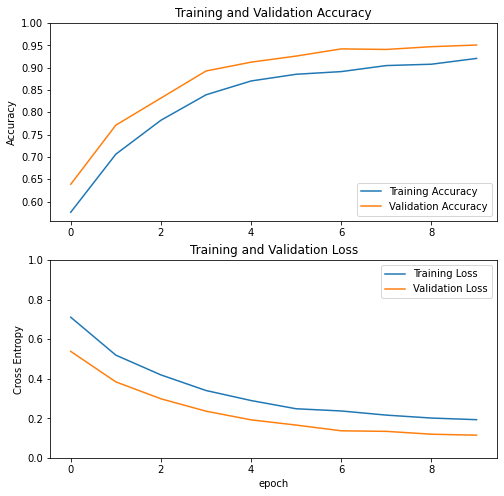

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [114]:
base_model.trainable = True

In [115]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [118]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [119]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [120]:
len(model.trainable_variables)

56

In [121]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 14s 106ms/step - loss: 0.1547 - accuracy: 0.9315 - val_loss: 0.0736 - val_accuracy: 0.9740
Epoch 11/20
63/63 [==============================] - 6s 96ms/step - loss: 0.1098 - accuracy: 0.9575 - val_loss: 0.0478 - val_accuracy: 0.9889
Epoch 12/20
63/63 [==============================] - 8s 114ms/step - loss: 0.1182 - accuracy: 0.9510 - val_loss: 0.0426 - val_accuracy: 0.9814
Epoch 13/20
63/63 [==============================] - 6s 85ms/step - loss: 0.0892 - accuracy: 0.9630 - val_loss: 0.0447 - val_accuracy: 0.9827
Epoch 14/20
63/63 [==============================] - 5s 76ms/step - loss: 0.0947 - accuracy: 0.9630 - val_loss: 0.0677 - val_accuracy: 0.9715
Epoch 15/20
63/63 [==============================] - 5s 71ms/step - loss: 0.0897 - accuracy: 0.9650 - val_loss: 0.0414 - val_accuracy: 0.9790
Epoch 16/20
63/63 [==============================] - 5s 80ms/step - loss: 0.0679 - accuracy: 0.9700 - val_loss: 0.0405 - val_accuracy: 0.9827
Epo

In [122]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

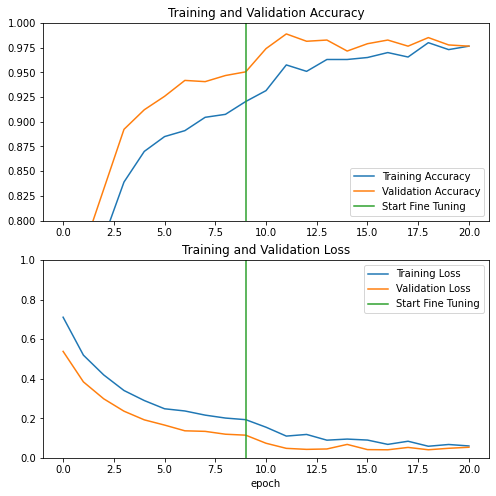

In [123]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [124]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 45ms/step - loss: 0.0916 - accuracy: 0.9635
Test accuracy : 0.9635416865348816


Predictions:
 [0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 0]
Labels:
 [0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 0]


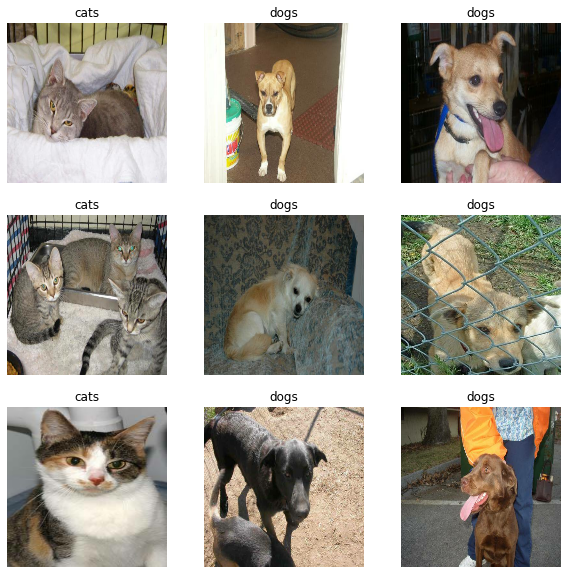

In [125]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## 과제 2
---

아래 대회 데이터를 이용해 모델을 구성해 보세요 (새로운 코랩 노트에서 실행하세요)

https://dacon.io/competitions/official/235585/overview/description

In [ ]:
# 조별 과제
# 조별로 대회 깃 레포지토리
# 깃 레포지토리 3명이서 공유하고, 같이 업데이트
# 레포지토리에 들어갈 내용 : 
# - 스크립트
# - 스크립트를 사용한 코랩 노트
# - ReadME.md 대회, 데이터 관련 설명
# 세명이서 분업 - 모델을 여러개 , 데이터증강법 다양하게 -> 엑셀에 정리

In [ ]:
# 기간 다음주 

# 2주동안 텍스트 (고전적인 텍스트 데이터 처리 과목...)
# 딥러닝 이용한 텍스트 처리
# 텍스트 딥러닝 + 랜드마크 분류 경진대회
# 2주 뒤에 이미지 / 텍스트 조 나눌것.

# 이미지 처리 : 분류만 했지만 / -> 검출 (detection), 분할 (segmentation) / ...

# 자연어 처리 : 텍스트 분류 / -> 음성인식 / 번역 / GPT / ...